In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
#declare a base
Base = automap_base() 

# reflect the tables
#Use the Base class to reflect the database tables 
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [14]:
#get a list of column names and types for measurement class
columns = inspector.get_columns('measurement')

for c in columns: 
        print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
#get a list of column names and types for station class
columns = inspector.get_columns('station')
for c in columns: 
        print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
# one year before to reverse
query_date = dt.date(2017,8,23)-dt.timedelta(days=365)

# print the dates
print(f"Query Timeline: {query_date} - {recent_date}")

Query Timeline: 2016-08-23 - 2017-08-23


In [60]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]

climate_dates = session.query(*sel).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

climate_dates

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(climate_dates, columns=['Date', 'Precipitation'])

# Set the index
climate_df.set_index('Date', inplace = True)

# Sort the dataframe by date
climate_df.sort_values(by= 'Date', ascending= True)


climate_df




,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


<function matplotlib.pyplot.show(*args, **kw)>

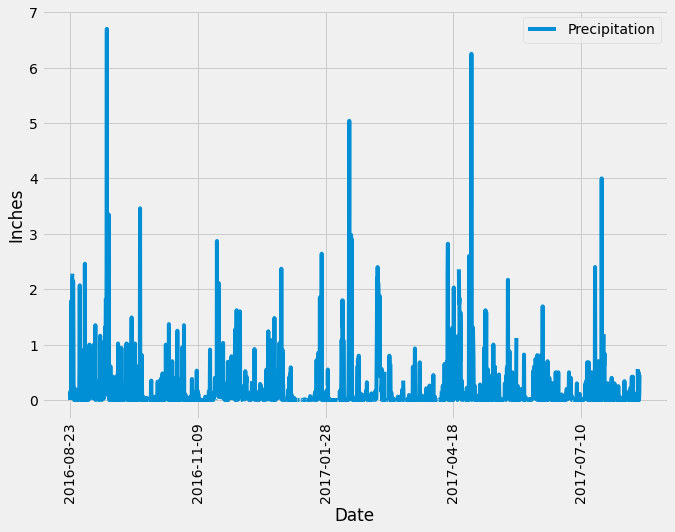

In [61]:
# Use Pandas Plotting with Matplotlib to plot the data

x_axis = climate_df.plot(figsize=(10,7))
x_axis.set_ylabel('Inches')
plt.xticks(rotation = 90)
plt.show

In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
station_count

print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [64]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations= session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.

most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

most_active


[(54.0, 85.0, 71.66378066378067)]

In [68]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this 
# station and plot the results as a histogram

most_active_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= query_date).\
order_by(Measurement.date.desc()).all()

most_active_tobs

tobs_df = pd.DataFrame(most_active_tobs)
tobs_df

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0
...,...
347,75.0
348,80.0
349,80.0
350,77.0


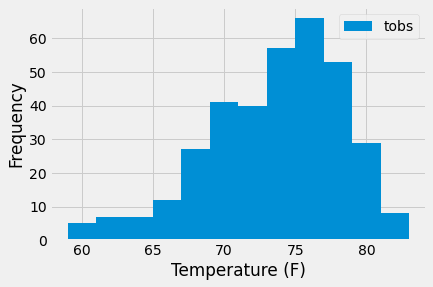

In [72]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this 
# station and plot the results as a histogram

tobs_df['tobs'].plot.hist(bins=12)

plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

# Close session

In [71]:
# Close Session
session.close()